In [293]:
#!pip install seaborn

import os
import sys
import pandas as pd
import random
import matplotlib.pyplot as plt
import sqlite3
from bs4 import BeautifulSoup, ResultSet
import warnings
from tqdm import tnrange, tqdm_notebook
from random import randint
import time 
import numpy as np

os.chdir('/home/chris/HOPE/data/') # Hardcoded!

In [294]:
# Load data that we already built in "data_build.ipynb"
db = sqlite3.connect("root_read.db")
cursor = db.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
authors = pd.read_sql_query("SELECT * from Author", db)
articles = pd.read_sql_query("SELECT * from Article", db)

authorcorr =  pd.read_sql_query("SELECT * from AuthorCorr", db)
cursor.close()
db.close()

# Articles workaround
articles_1 = articles[articles["CiteCount"] != "MISSING"]
articles_2 = articles[articles["CiteCount"] == "MISSING"]
articles_2["new"] = ""
articles_2 = articles_2.drop(columns = "Journal")
articles_2.columns = articles_1.columns
articles = articles_1.append(articles_2)
articles = articles[articles["Journal"] != "P&P"]
# Now Build AuthorAlias table 
# Note: This is done sequentially AFTER updating Author and Article tables, since it depends on those :) 
#key = pd.read_csv("key.csv", header = None)
# key.columns = ["metadata", "clean name", "confirmed name", "Sex"]


<ipython-input-294-22e1c3758a10>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_2["new"] = ""


In [295]:
authorcorr

,AuthorID,ArticleID,AuthorOrder
0,191,2795,0
1,489,2796,0
2,3953,2796,0
3,1232,2797,0
4,162,2797,0
...,...,...,...
37336,3867,28910,MISSING
37337,3886,28911,MISSING
37338,12096,28911,MISSING
37339,4628,28912,MISSING


In [297]:
# Technical debt: these are leaking somehow! Need to go back and fix them. 

titles_1 = articles.Title.str.lower()

def list_duplicates(seq):
    seen = set()
    seen_add = seen.add
    # adds all elements it doesn't know yet to seen and all other to seen_twice
    seen_twice = set( x for x in seq if x in seen or seen_add(x) )
    # turn the set into a list (as requested)
    print(len(list( seen_twice )))
    return(list( seen_twice ))

list_duplicates(titles_1) 


152


['realism and relevance in the theory of demand',
 'organizational design and technology choice under intrafirm bargaining:',
 'theory of balance-of-payments adjustment - comment',
 'the international bank for reconstruction and development',
 'rejoinder',
 'the graduation of income distributions',
 'the economic articles in the quarterly review and their authors, 1809-52',
 'welfare implications of the taxation of savings',
 'rationale of mean-standard deviation analysis - comment',
 'the economics of price scissors - comment',
 'credit risk and credit rationing - comment',
 'regression with non-gaussian stable disturbances - some sampling results',
 'inequality aversion, efficiency, and maximin preferences in simple',
 'european unification and the dollar problem',
 'reversals of assumptions and implications',
 'a further note on dynamic economics',
 'demand and supply factors in the determination of nie exports - a',
 'intergenerational wealth transfers and educational decisions of 

In [302]:
# Test for data integrity before we analyze the data 

def ArticleID_query(ID):
    
    data = articles[articles["ArticleID"] == ID]
    data1 = authorcorr[authorcorr["ArticleID"] == ID] 
    data1 = list(set(data1.AuthorID))
    data1 = authors[authors['AuthorID'].isin(data1)]
    
    print("ArticleID: " + str(data.iloc[0,0]))
    print("Journal: " + str(data.iloc[0,1]))
    print("Published in year: " + str(data.iloc[0,2]))
    print("Title: " + str(data.iloc[0,3]))
    print("Volume: " + str(data.iloc[0,9]))
    print("Issue: " + str(data.iloc[0,10]))
    print("There are " + str(len(data1)) + " co-authors on this paper:" )
    
    print(set(data1.AuthorName))

#def Author_query(First, Last):
    
ArticleID_query(25229.0)

# Search bu Author

# Search by Article UD


ArticleID: 25229
Journal: QJE
Published in year: 1961
Title: THE COMMISSION ON MONEY AND CREDIT
Volume: 4
Issue: MISSING
There are 1 co-authors on this paper:
{'Arthur Smithies'}


In [303]:
# Is there a better way of searching for comments?
articles[articles['Title'].str.contains("Comment")].head()

,ArticleID,Journal,PubDate,Title,Abstract,Language,Received,Accepted,Volume,Issue,Part,FirstPage,LastPage,Comments,CiteCount,Note
316,317,ECA,1991-07-01,Comments on the Interpretation of Game Theory,The paper is a discussion of the interpretatio...,English,1988-08-01,1990-08-01,59,4,1,909,924,None,158,None
1042,1044,ECA,1980-03-01,"Comments on Roth's Paper, ""Values for Games wi...","In his paper, Roth has used a three-person gam...",English,1978-12-01,1978-12-01,48,2,1,477,477,None,7,None
1308,1310,ECA,1977-01-01,Non-Price Rationing of Intermediate Goods in C...,This paper investigates an operational inconsi...,English,1975-04-01,1975-10-01,45,1,1,175,181,None,1,None
1959,1961,ECA,1963-07-01,Substitution versus Fixed Production Coefficie...,"In a recent issue of Econometrica, Leif Johans...",English,None,None,31,1/2,1,209,217,None,7,None
2013,2015,ECA,1961-07-01,The Estimation of Distributed Lags: A Comment,This note discusses a technical difficulty in ...,English,None,None,29,3,1,430,433,None,5,None


No handles with labels found to put in legend.


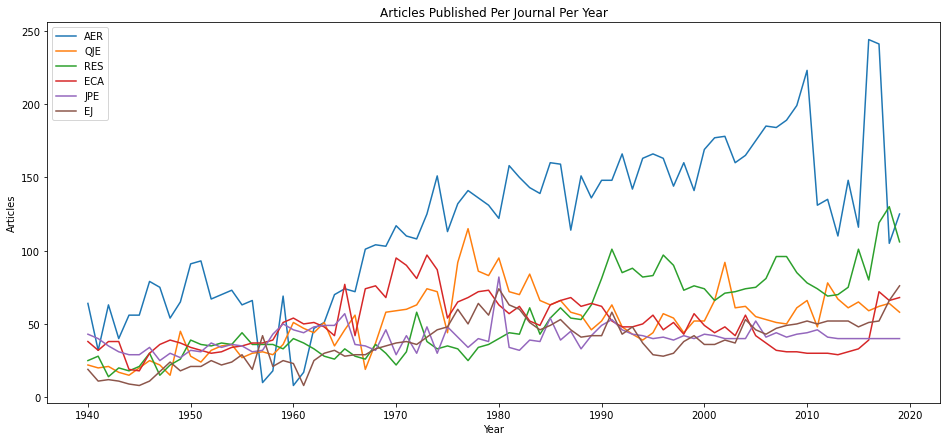

{'RES', 'AER', 'EJ', 'QJE', 'JPE', 'ECA'}


In [305]:
# Plot a simple count of published articles per year per journal

articles["PubDate"] = pd.to_numeric(articles['PubDate'].astype(str).str[:4])
df = articles.groupby(['Journal',"PubDate"]).count() # technical debt - naming conventions
df["journal"] = df.index.get_level_values(0) 
df["PubDate"] = df.index.get_level_values(1)
df.index = range(0, len(df))
df = df[df["PubDate"] < 2020] # Why?
df = df[~df['journal'].str.contains("P&P")]
fig, ax = plt.subplots(figsize=(16,7))
ax.set_title('Articles Published Per Journal Per Year')

for unq_value in df['journal'].unique():
    mask = df['journal'] == unq_value
    df_subset = df[mask]
    plt.plot(df_subset['PubDate'], df_subset['ArticleID'])
ax.set_xlabel('Year')
ax.set_ylabel('Articles')
ax.legend(loc='upper left')
ax.legend(['AER', 'QJE', 'RES', 'ECA', 'JPE', 'EJ'])
plt.show()
print(set(df.journal))

# Investigate that blue spike 

No handles with labels found to put in legend.


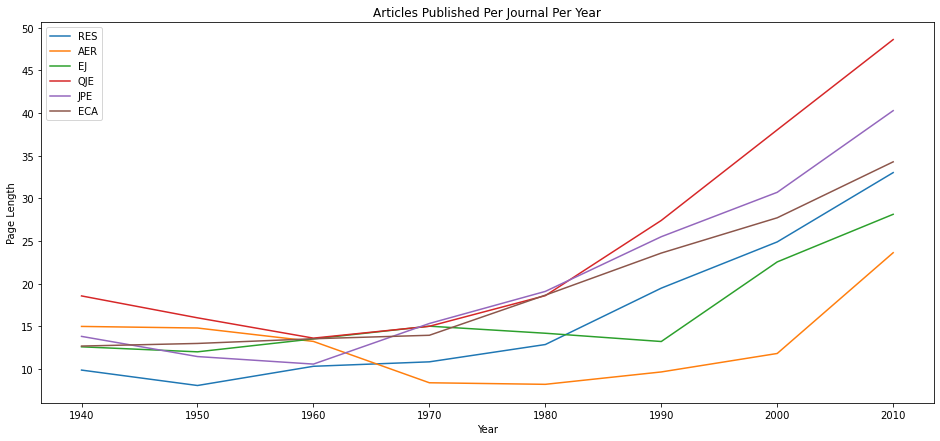

In [306]:
articles["decade"] = ""
articles["pages"] =  pd.to_numeric(articles["LastPage"], errors='coerce') - pd.to_numeric(articles["FirstPage"] , errors='coerce')
articles = articles[articles["Journal"] != "P&P"]

def decades(data, lower, upper, name):
    data['decade'] = np.where((data['PubDate'] > lower) & (data['PubDate'] < upper), name ,data['decade'])
    return(data)

articles = decades(articles, 1939, 1950, 1940)
articles = decades(articles, 1949, 1960, 1950)
articles = decades(articles, 1959, 1970, 1960)
articles = decades(articles, 1969, 1980, 1970)
articles = decades(articles, 1979, 1990, 1980)
articles = decades(articles, 1989, 2000, 1990)
articles = decades(articles, 1999, 2010, 2000)
articles = decades(articles, 2009, 2020, 2010)

articles = articles[articles["decade"] != ""]
page_count = pd.DataFrame([])
for journal in set(articles.Journal):
    data = articles[articles["Journal"] == journal]
    grouped = data.groupby(["decade"])
    grouped = pd.DataFrame(grouped.agg(np.mean))
    grouped["Journal"] = journal
    grouped["Decade"] = grouped.index
    grouped = grouped.sort_values(by = "Decade")
    grouped = pd.DataFrame(grouped[["pages","Journal", "Decade"]])
    page_count = page_count.append(grouped)

fig, ax = plt.subplots(figsize=(16,7))
ax.set_title('Articles Published Per Journal Per Year')
for unq_value in page_count['Journal'].unique():
    mask = page_count['Journal'] == unq_value
    df_subset = page_count[mask]

    plt.plot(df_subset['Decade'], df_subset['pages'])
ax.set_xlabel('Year')
ax.set_ylabel('Page Length')
ax.legend(loc='upper left')
ax.legend(['RES', 'AER', 'EJ', 'QJE', 'JPE',  'ECA'])
plt.show()



In [321]:
# Mean Number of Co-Authors per Decade 

articles["n_Authors"] = ""
articles["n_male_Authors"] = ""
articles["n_female_Authors"] = ""
articles["n_unknown_authors"] = ""

coauthors = pd.DataFrame([])
for article in tqdm_notebook(set(articles.ArticleID)):
    
    data = authorcorr[authorcorr["ArticleID"] == article]
    length = len(data)
    data = data.merge(authors, on="AuthorID")
    male = len(data[data["Sex"] == "Male"])
    female = len(data[data["Sex"] == "Female"])
    data = pd.DataFrame([])
    data["authors"] = pd.Series(length)
    data["female"] = pd.Series(female)
    data["male"] = pd.Series(male)
    coauthors = coauthors.append(data)

<ipython-input-321-adf453254496>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for article in tqdm_notebook(set(articles.ArticleID)):


<ipython-input-382-b85d22667bc2>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for journal in tqdm_notebook(set(df.Journal)):


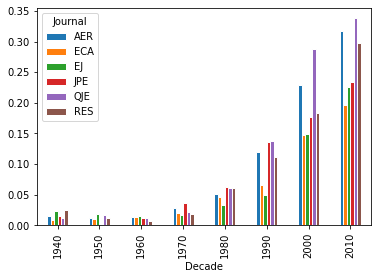

In [409]:

#fig, ax = plt.subplots(figsize=(16,7))
#ax.set_title('Rise of Coauthoring')
#for unq_value in set(database['Journal']):
#    
#    mask = database['Journal'] == unq_value
#    df_subset = database[mask]
#    print()
#    plt.plot(df_subset['Decade'], df_subset['Female'])

#rearrange dataframe and plot
database['Female'] = pd.to_numeric(database['Female'])
database.pivot(index = "Decade", columns = "Journal", values = "Female").plot.bar(edgecolor = "white")
#plt.xticks(rotation = 0)
#plt.show()

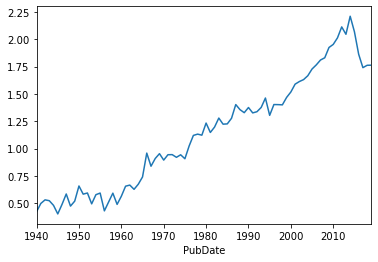

In [424]:
# Rise of Coauthors

# Multiple KDEs
df = pd.concat([articles.reset_index(drop=True), coauthors.reset_index(drop=True)], axis=1)

df = df.groupby(['PubDate']).mean()
df["authors"].plot()


In [446]:
# Most prolific authors per 
for unq_value in set(articles['decade']):
    
    data = articles[articles['decade'] == unq_value]
    data = authorcorr[authorcorr['ArticleID'].isin(list(set(data.ArticleID)))]
    data = data.merge(authors, on="AuthorID")
    female = data[data["Sex"] == "Female"]
    male = data[data["Sex"] == "Male"]
    female = female['AuthorName'].value_counts()[:10]
    print("Decade is: " + str(unq_value))
    print(female)


Decade is: 1990
Janet Currie           10
Christina H. Paxson     8
Anne C. Case            8
Melinda C. Miller       7
Claudia D. Goldin       7
Valerie A. Ramey        6
Raquel Fernández        6
Marianne Baxter         5
Anne O. Krueger         5
Judith A. Chevalier     5
Name: AuthorName, dtype: int64
Decade is: 1960
Irma Adelman            6
Anne O. Krueger         5
M. June Flanders        2
Ann F. Friedlaender     2
Nancy L. Schwartz       2
Zivia S. Wurtele        1
Grace Wahba             1
Joyce E. Pickersgill    1
Judith Thornton         1
Kanta Marwah            1
Name: AuthorName, dtype: int64
Decade is: 2000
Marianne Bertrand    15
Susan Athey          13
Amy Finkelstein      12
Esther Duflo         12
Petra E. Todd         9
Anne C. Case          8
Sandra E. Black       7
Janet Currie          7
Muriel Niederle       6
Wendy A. Stock        6
Name: AuthorName, dtype: int64
Decade is: 1970
Nancy L. Schwartz      9
Anne O. Krueger        5
Barbara R. Bergmann    5
Irma Ade

In [453]:
articles.columns

Index(['ArticleID', 'Journal', 'PubDate', 'Title', 'Abstract', 'Language',
       'Received', 'Accepted', 'Volume', 'Issue', 'Part', 'FirstPage',
       'LastPage', 'Comments', 'CiteCount', 'Note', 'decade', 'pages',
       'n_Authors', 'n_male_Authors', 'n_female_Authors', 'n_unknown_authors'],
      dtype='object')

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


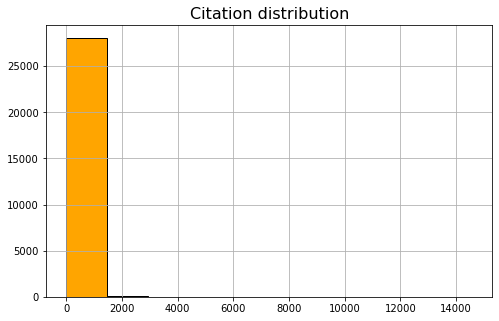

In [456]:
articles['CiteCount'] = pd.to_numeric(articles['CiteCount'])
plt.figure(figsize=(8,5))
plt.title("Citation distribution",fontsize=16)
plt.grid(True)
plt.hist(articles['CiteCount'],color='orange',edgecolor='k')
plt.show()

In [322]:
# Most common co-authoring Duos

# Most common co-authoring Trios

# Citations

# Network Analysis

# Run a regression using logit 

# Most common co-author pairs 